#  5. Regression Analysis 
## Abdullah Karasan

In finance, it is highly likely that we need an algorithm that generates outputs with continuous numerical values. No matter how old it is, it has been highly acknowledge technique. Still, it is one of the most preferable model in academic and business world.

Surely, there are some solid reasoning why it is a such a highly appreciated model. First and foremost, it has a closed form solution so that we have global optimum point. In addition to that it is rather intuitive and easy-to-follow and easy-to-apply technique. In this lesson, we will learn the regression analysis from both theoretical and empirical standpoint.

Let's examine the general structure of linear regression. Our ultimate aim is to find a relationship between dependent variable and independent variable(s). Dependent variable is a variable that we try to explain using somewhat correlated variables called independent variable. We may have more than one independent variables, it is called `multivariate` case and if we have only one independent variable, it is known as `univariate` case. Needles to say, dependent variable should be single variable.

Mathematically speaking,

$$ y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \epsilon \qquad$$

$y$ denotes the dependent variable and $x_1, x_2,..., x_n$s represent the independent variables. In linear regression, our ultimate aim is to estimate the coefficients, which are represented by $\beta_0$, $\beta_1$,...,$\beta_n$. To be more specific, $\beta_0$ is called intercept term or bias and the other $\beta$ parameters are called slope coefficient. Finally, $\epsilon $ is the error term, which store the information that is not explained by independent variables. If we do not have the $\epsilon$ term, the analysis is no longer a statistical analysis but a deterministic one.

At this point, it would be helpful to run a regression example as we are about to check if the result we get from regression analysis satisfy the Gauss-Markov assumptions. Our dataset is about the relationship of ingredients of red and white wine and the quality of them.

Let's first import libraries and the dataset. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression 
import statsmodels.api as sm
import plotly.graph_objs as go
import plotly.offline as py
import warnings
warnings.filterwarnings('ignore')

I'll apply linear regression model on a medical cost dataset from Kaggle, which is called "Medical Cost Personal Dataset" and can be found at this [link](https://www.kaggle.com/mirichoi0218/insurance).




The data is about the costs charged by the insurance companies to individuals. These are costs that the insured individuals were required to pay after the insurance company made payments to medical providers. 

The dataset includes six variables as described below:

* age: The age of the individual. It's a numeric.
* sex: The biological sex of the insured. It is categorical (male or female).
* bmi: Body mass index. This index indicates whether an individual's weight is relatively high or low, based on height. This index defines an ideal range between 18.5 and 24.9. The variable is continuous.
* children: How many dependent children the insured person has. Dependents are covered by the insurance plan. This is a numeric variable.
* smoker: This categorical variable (yes | no) indicates or not the person smokes.
* region: The person's residential area in the US. It's a categorical variable (northeast, southeast, southwest, northwest).
* charges: The medical costs (in US dollars) billed by the insurance company. It's a continuous variable.

In the examples, the target variable is "charges" billed by the insurance company. Since, it's a continuous variable, we're dealing with a regression task.


In [2]:
insurance_df=pd.read_csv('../datasets/insurance.csv')

Let's observe the data before moving on:

## 5.1. Preliminary data exploration

In [3]:
insurance_df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


First, let's look at the distribution of our target variable: `charges`. Investigating how our target is distributed helps us understand the relationship between the target and the features. It's also useful to discover some potential problems with our model as we'll discuss in the next lesson:

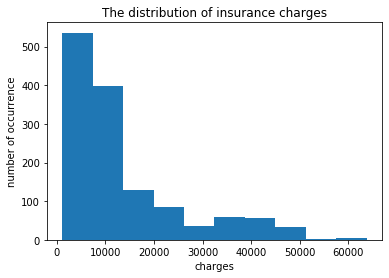

In [4]:
plt.hist(insurance_df.charges)
plt.title("The distribution of insurance charges")
plt.xlabel("charges")
plt.ylabel("number of occurrence")
plt.show()

It is readily observable that charges is not distributed normally. Instead it's highly skewed. Skewness is a measure of how asymmetric our data is with respect to the normal distribution. As we see in the graph, the charges variable is not symmetric but skewed to the right. The majority of the observations have low charges values and few of the observations have high charges values. This makes the distribution of the charges clustered at the left-most part of the histogram.

Notice that the categorical variables are strings and we need to convert them to numerical values. This can be viewed as part of the feature engineering process. One of the most convenient ways of converting categorical variables into numerical ones is called one hot encoding. In one hot encoding, we create a sperate binary variable which takes 0 or 1 for each of the unique values of the categorical variable. Pandas' get_dummies() function does this job for us.

In [5]:
insurance_df["is_male"] = pd.get_dummies(insurance_df.sex, drop_first=True)
insurance_df["is_smoker"] = pd.get_dummies(insurance_df.smoker, drop_first=True)

After discretization of the variable, I would like to examine the gender and smoker effects on the insurance charge. At a first glance, gender and smoking may play an important role in the insurance charges. So, let's look at whether we see some differences between the average costs billed to different genders and to those who smoke:

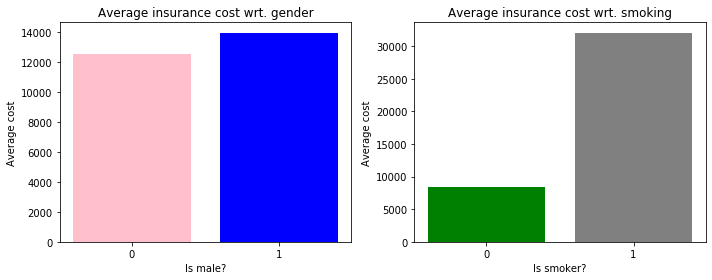

In [6]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(insurance_df.groupby("is_male")["charges"].mean().index, insurance_df.groupby("is_male")["charges"].mean(),
       color=("pink","blue"))
plt.title("Average insurance cost wrt. gender")
plt.ylabel("Average cost")
plt.xlabel("Is male?")
plt.xticks([0,1])

plt.subplot(1,2,2)
plt.bar(insurance_df.groupby("is_smoker")["charges"].mean().index, insurance_df.groupby("is_smoker")["charges"].mean(),
       color=("green","grey"))
plt.title("Average insurance cost wrt. smoking")
plt.ylabel("Average cost")
plt.xlabel("Is smoker?")
plt.xticks([0,1])

plt.tight_layout()
plt.show()

Yes it does, being male and smoker result in higher insurance charges.

## 5.2. Modeling the insurance charges with linear regression¶

$$charges=\beta_0+\beta_1\text{is_smoker}+\beta_2\text{is_male}+\epsilon$$

In [7]:
# Y is the target variable
Y = insurance_df['charges']
# X is the feature set which includes
# is_male and is_smoker variables
X = insurance_df[['is_male','is_smoker']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [  -65.37843464 23622.1345855 ]

Intercept: 
 8466.035826716778


** Quick Note: Putting a constant in a model is optional, but it's a good idea to include a constant in every model you build. Even though you think that the constant would be zero, letting the OLS to decide whether it is zero or not is the safest way.

In [8]:
# Y is the target variable
Y = insurance_df['charges']
# X is the feature set which includes
# is_male and is_smoker variables
X = insurance_df[['is_male','is_smoker']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [  -65.37843464 23622.1345855 ]

Intercept: 
 8466.035826716778


`LinearRegression()`'s `fit()` method runs OLS algorithm by default. Since we get the parameters using OLS, we can write our estimated model:

$$charges=8466.04+-65.37\text{is_smoker}+23622\text{is_male}+\epsilon$$

According to the estimation results, constant term is 8466.04. Estimated coefficients of `is_male` and `is_smoker` features are -65.38 and 23622.14 respectively. Later in this module, we'll delve into how to interpret these estimated coefficients.

In [9]:
import statsmodels.api as sm

# We need to add constant manually 
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     1088.
Date:                Wed, 26 Aug 2020   Prob (F-statistic):          4.78e-281
Time:                        20:39:51   Log-Likelihood:                -13831.
No. Observations:                1338   AIC:                         2.767e+04
Df Residuals:                    1335   BIC:                         2.768e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8466.0358    303.541     27.891      0.000    7870.566    9061.506
is_male      -65.3784    409.809     -0.160      0.873    -869.318     738.561
is_smoker   2.362e+04    507.736     46.524      0.000    2.26e+04    2.46e+04
==============================================================================
Omnibus:                      135.842   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.897
Skew:                           0.727   Prob(JB):                     9.71e-47
Kurtosis:                       4.299   Cond. No.                         2.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

First notice that we added constant to our existing feature set using this code: `X = sm.add_constant(X)`. This is because, `statsmodels'` `fit()` function doesn't add constant by default as opposed to scikit-learn's fit() function.

Second, when we call the `summary()` function on the fitted ols model, it prints out a table full of some statistics. For example, in the upper side of the table we see statistics like R-squared, adjusted R-squared, F-statistic, Log-likelihood, AIC and BIC. Those are related with the goodness of fit of our model. 

Let's interpret the result we have after running the regression analysis. The topics we are about to touch are:
* Statistical significance
* t-test
* p-value
* Inference 

The individual coefficients are assessed based on their statistical significance and it is not guaranteed that estimated coefficient are statistically significant. Moreover, it is not a rare event to have statistically insignificant coefficient in the regression.

For an individual coefficient to be statistically significant, it must explain some variance in the dependent variable. To do that its value should be higher than its standard deviation. Generally speaking, there are two statistical tools that helps us to interpret whether the individual coefficient is statistically significant or not:
* t-test
* p-value

**t-test** is used to determine if estimated coefficient is zero or not. The null hypothesis tells that the estimated coefficient is zero and the alternative hypothesis tells the other way round:

$$ H_0: \beta=0\\
H_A: \beta\neq 0$$

If $\beta$ is zero, it indicates the statistical insignificance of the estimated coefficient. If $\beta$ is greater than zero, it means that the estimated coefficient is statistically significant. In order to assess t-test result, we compare two things: `Critical value for t-test` and the `t-test value` we get from the regression analysis. 

If the t-test value is greater than critical value for t-test, then it implies that the individual coefficient is statistically significant. The critical value for t-test is determined based on the `degrees of freedom`, `df` for short. Degrees of freedom is  the number of parameters of a statistic that are free to vary. We have 2 estimated coefficient, which are free to vary. 

In the model output given above, the degree of freedom of our model is abbreviated as `Df Model`and it is 2. Based on the critical value table below, we have different values corresponding to the degrees of freedom of 2. Once we set our confidence interval to 95%, which is generally the conventional level, we have 2.920. Thus, let's check if we have any t-test result for estimated coefficient which is greater than the critical value of 2.920.

* is_smoker

<img src="../assets/t_test_critical_value.png" alt="Critical Values for t-test" style="width:400;height:600px;">

There is another way to interpret the statistical significance of the individual coefficients, which is `p-value`. It is easier way to apply. All we need to know is the significance level which is the complements of confidence interval. That is to say, suppose we are working with 95%, our corresponding significance level becomes 5%. In this case, if we have a p-value less than 0.05, then we accept the alternative hypothesis suggesting that the estimated coefficient is greater than zero, i.e it is statistically significant.

Briefly, we can conclude that only `is_smoker` have explanatory power (or statistically significant) on charges.

Now, we are ready to interpret the estimated coefficient. Firstly, as it is clear that only the statistically significant estimated coefficients can be interpreted. Simpy because, statistically insignificant variables does tell anything to us. Therefore `is_smoker` is the only one I will interpret. Accordingly, 1-unit increase in `is_smoker` leads to an increase in charges by 2.362e+04.

One of the most distinctive feature of linear regression is that it is a parametric approach and therefore it has certain assumption to satisfy. These assumptions should be met in order for estimated coefficients to be valid and test statistics associated with them to be reliable. These assumptions are called `Gauss Markov Assumptions`.

Thus, before interpreting the coefficient and running a predicting analysis, we should make sure that all these assuptions are satisfied. At this points, let's discuss the assumptions now:

## 2.1. Assumptions

* Linearity of the coefficients
* Constant Variance (Homoscedasticity)
* Low multicollinearity
* Uncorrelated error terms
* Independent variable should not be correlated with the errors
* The error term should, on average, be zero 

### 5.2.1. Linearity of the coefficients 

The concept of linearity can sometimes be found confusing. Linearity in linear regression implies linearity in the coefficient not inthe variables. Linear regression can account for quadratic or cubic relationship between dependent and independent variables but by using linear coefficients. In mathematical terms:

$$ y = \beta_0 + \beta_1x_1 + \beta_2x_2^2 + \epsilon $$

We should not have something like this:

$$ y = \beta_0 + \beta_1x_1 + \beta_2^3x_2 + \epsilon$$

Let's briefly explain how regression explain non-linear relations. To this end, we use `linear_model` library from sklearn library, which is widely used Machine Learning library in Python. I first randomly generate X and Y values. The former represents independent variable and the latter denotes the dependent variable. Then, I calculate the third power and 


Coefficients: 
 [2. 3.]

Intercept: 
 0.9999999997671694


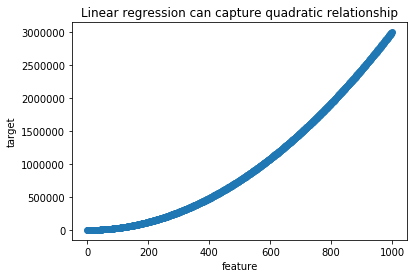

In [10]:
df = pd.DataFrame()

# data from 0 to 999
df["X"] = np.arange(0,1000,1)
# we take the square of X
df["X_sq"] = df["X"]**2

# this is our equation: Y = 1 + 2*X + 3*X^2
df["Y"] = 1 + 2*df["X"] + 3*df["X_sq"]

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df[["X","X_sq"]],df["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(df[["X","X_sq"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

It is readily observable that the relationship between X and Y is not linear and linear regression model is able to capture this non-linear relationship.

### 5.2.2. The error term should be zero on average

This second assumption states that the expected value of the error term should be zero. In mathematical terms:

$$\mathbb{E}(\epsilon)=0$$

The 𝔼 symbol indicates the expectation operator. We can read it as "the average of the error terms should be equal to zero". Error term accounts for the variation in the target variable that is not explained by the features. So, ideally the error term shouldn't explain anything in the variation of the target variable but instead should be determined randomly. If the expected value of the error is different than zero, our model would become biased! For example, if  𝔼(ϵ)=−1, then it means that our model systematically overpredicts the target variable.

This assumption is not held if you forget to include the constant term in your model. This is why we said that you should always include a constant in your model. As long as we include a constant in a model, we shouldn't be worried about this assumption as the constant will force the error terms to be zero on average.

In our medical costs model, we can see this happening:

In [14]:
predictions = lrm.predict(insurance_df[['is_male','is_smoker']])
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -5.804996078580574e-13


### 5.2.3. Constant Variance

In linear regression, the distribution of error terms should be consistent across all predicted values. In order to satisfy this, error variance should be constant, i.e. it should not systematically change across observations. If the error variance is constant across observations, it is called `homoscedasticity`. On the contrary, if the distribution of error variance varies across observations, it is called `heteroscedasticity`.

For example, if our error terms aren't consistently distributed and you have more variance in the error for large outcome values than for small ones, then the confidence interval for large predicted values will be too small because it will be based on the average error variance. This leads to overconfidence in the accuracy of our model's predictions.



Let's checkout whether our medical costs model suffers from the heteroscedasticity by visualizing it:

In [ ]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

It seems that the variances of the errors are higher for the higher values of the target variable. This implies that our error terms aren't homoscedastic. However, deriving conclusions from visuals is only an informal way of figuring out the problem. Thankfully, there are several formal statistical tests that we can use to determine whether there is heteroscedasticity in the error terms.

That's bad. It seems like we have heteroscedasticity problem here. There is also a scientific way to decide if the errors are heteroscedastic or not, which is called `Bartlett and Levene` test`.

In [ ]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_result = bartlett(predictions, errors)
lev_result = levene(predictions, errors)



In [ ]:
print("Bartlett test statistic value is {} and p value is {}".format(bart_result[0], bart_result[1]))
print("Levene test statistic value is {} and p value is {}".format(lev_result[0], lev_result[1]))

The result (p-value and test statistic) confirms that there is a heteroscedasticity as alternative hypothesis is accepted. The bad news is that, if any of the linear regression assumption fails, the result of the linear regression is not reliable any more. But, no worries, there is a statistical methods to get rid of it. One of them is `Box-Cox Transformation`. Please see this [document](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.power_transform.html) to see the Box-Cox Transformation application in Python.

### 5.2.4. Multicollinearity

To have the isolated effects of the independent variables on the dependent variable, there should not be high correlation between independent variables. Only week correlation between independent and dependent variables are allowed in linear regression. If high correlation among independent variables occurs, which is called `multicollinearity`, these highly correlated features can account for same pattern of variance in the dependent variable. The multicollinearity turns into a problem when we want to know the explanatory power of the independent variables as it underestimates the relationship between independent and dependent variables.



There are two common ways to detect multicollinearity:
    * Checking correlation coefficient
    * Variance Inflation Factor

As we discuss, high correlation is a signal for multicollinearity. So, the important question here is after what level of correlation, can it be called high correlation. 

As for the Variance Inflation Factor, VIF for short, the thresholds are given below:
* If VIF=1, no correlation
* 1< VIF> 5, moderately correlation
* VIF>5, highly correlation   

Let's first check the correlation table. But first we need to make a small adjustment. As we have constant term in X data frame, we need to get rid of it because it is not a variable just a constant in our regression model. The below given `.iloc()` does this.

In [ ]:
insurance_df

Well, as the only continuous variable in the dataset is `bmi`, there is unlikely to have a multicollinearity.

### 5.2.5. Uncorrelated Error Term

Error terms cannot be predictable. They should be independently distributed. Shortly, errors terms should be uncorrelated with each other. If there is a correlation between error terms, it is called `serial correlation`. Serial correlation arise if we omit an independent variable, which has an explanatory power on the dependent variable.

In order to detect if the error term is uncorrelated, visualization may be good option. The graph of error term should fluctuates around zero. Alternatively, we apply `autocorrelation function` telling us correlation among the lag values of the variable.

In [ ]:
plt.plot(errors)
plt.show()

Here, by eyeballing, it is readily observable that error term fluctuates around zero with no trend. Let's check the autocorrelation function and interpret the result.

In [ ]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data)
plt.show()

If the `autocorrelation function` (acf) decays fast, it implies that error term is stationary, i.e there is no serial correlation among error terms. The acf graph above exhibits that after five lag, it turns out that autocorrelation function approaches zero and stays there constantly. This confirms that there is no serial autocorrelation.

### 5.2.6. Independent variable should not be correlated with the errors

Error should not be correlated with independent variables. Because any correlation between these two implies that there is a omitted variable problem. In other words, a variable needs to be included in the regression is represented in the error term and this leads to a bias. This assumption is known as the `exogeneity`.

Potential sources of exogeneity may be:
* Omitted variables and 
* Simultaneous causation between independent variables and the target.

# Conclusion

As a widely accepted and employed tool, regression analysis is our very first modeling tool. As we discuss throughout the lesson, it has applicable to wide range of areas. Even if it an old technique, we still see that this model is prefered by top researchers. Now, it is your time to explore this model more.